### 2.8 WP4: Solution of Navier's Equation for the Stress Field

#### 2.8.1 Exercise 1: Stresses around a wellbore

Consider a 2D problem of a circular cavity subjected to far field effective stresses $\sigma_{xx}$ = 12 MPa and $\sigma_{yy}$ = 3 MPa. The diameter of the cavity is 0.2 m. Rock properties: $E$ = 10 GPa, $\nu$ = 0.20, unconfined compression strength $UCS$ = 30 MPa, tensile strength $T_s$ = 2 MPa.

1. Using Kirsch equations compute (and plot) $\sigma_{rr}$, $\sigma_{\theta\theta}$ and $\sigma_{r\theta}$ for a domain $x$ = [-1m, +1m], and $y$ = [-1m, +1m]. You may define a polar grid for $(r,\theta)$. How far does the presence of the wellbore influence stresses?

1. Using Kirsch equations compute (and plot) stresses in a line ($x$ = [0.1m, 1m], $y$ = 0 m) and ($x$ = 0 m, $y$ = [0.1 m, 1 m]). Equations in Ch. 6.2 (https://dnicolasespinoza.github.io/)

1. Using Kirsch equations compute (and plot) $\sigma_{rr}$ and $\sigma_{\theta\theta}$ for $r$ = 0.1 m. Is there any section of the rock in shear or tensile failure? Where?

1. Use FreeFEM++ (http://www3.freefem.org/) or FEniCS (https://fenicsproject.org/) to solve the same problem ( $\sigma_{xx}$, $\sigma_{yy}$ and $\sigma_{xy}$) assuming a domain size 2 m by 2 m. Compute $\sigma_{xx}$ and $\sigma_{yy}$ for the same lines as in point (b), and compare with Kirsch's analytical solution. Repeat the process for a domain size 0.5 m by 0.5 m. Are there any differences? Why?

1. Plot the displacement field.

1. EXTRA: compute principal stresses within FreeFEM++ and plot $\sigma_{rr}$ and $\sigma_{\theta\theta}$.

Hint: An example code for 2D elasticity in FreeFEM++ and the corresponding explanation are available at https://github.com/dnicolasespinoza/GeomechanicsJupyter/: Kirsch_Shovkun.edp and FreeFEM_Tutorial_Shovkun.pdf. You can also try FreeFEM++ online here: https://freefem.org/tryit.

#### 2.8.2 Exercise 2: Stresses around a planar fracture

Consider a 2D problem of an elliptical fracture (half-length $c$ = 10 m). Solve the problem using just half of the domain. Set the fracture along the left boundary of a domain: $x$ = [0 m, 100 m] and $y$ = [-50 m, 50 m], with fracture center at $(x,y)=$ (0,0) m. This boundary will have a pressure boundary condition. All other boundaries will have zero displacement. Rock properties: $E$ = 30 GPa, $\nu$ = 0.20.

1. Use FreeFEM++ (http://www3.freefem.org/) or FEniCS (https://fenicsproject.org/) to solve for $\sigma_{xx}$, $\sigma_{yy}$ and $\sigma_{xy}$ imposing a fracture pressure $p$ = 10 MPa. Plot results.
Export and plot stress perpendicular to the fracture direction $\sigma_{xx}$ at the middle of the fracture (L1 = ($x$ = [0, 100 m], $y$ = 0 m), Figure 2.32). How far does the influence of the fracture extend?

1. Plot $x$-displacements at the face of the fracture. Compare with analytical equation. Equations in Ch. 7.3.2 (https://dnicolasespinoza.github.io/).

1. Plot $\sigma_{xx}$ along fracture length and beyond fracture tips (line L2 = ($x$ = 0 m, $y=$ [-50, 50]) m, Figure 2.32) and compare with analytical Griffith solution.

1. EXTRA: compare FreeFEM++ solution to analytical solution by Sneddon and Elliot, 1946. (Eq. 20 in https://doi.org/10.1016/j.fuel.2017.01.057).

In [1]:
# Support functions
import numpy as np
import matplotlib.pyplot as plt

def kirsch_rt( r, theta ) :
    global R, pw, s1, s2

    R_div_r = R / r
    sigtt = 1/2 * ( s1 + s2 - 2*pw ) * ( 1 + R_div_r**2 ) \
          - 1/2 * ( s1 - s2 ) * ( 1 + 3 * R_div_r**4 ) * np.cos(2*theta) \
          - pw * R_div_r**2

    sigrt = 1/2 * ( s1 - s2 ) * ( 1 + 2 * R_div_r**2 - 3*R_div_r**4 ) * np.sin(2*theta)


    sigrr = 1/2 * ( s1 + s2 - 2*pw ) * ( 1 - R_div_r**2 ) \
            + 1/2 * ( s1 - s2 ) * ( ( 1 - 4 * R_div_r**2 + 3 * R_div_r**4 )) * np.cos(2*theta) \
            + pw * R_div_r**2
    
    return sigtt, sigrt, sigrr

def kirsch(x,y) :
    r = np.sqrt( y**2 + x**2 )
    theta = np.arctan2( y , x )
    return kirsch_rt( r, theta )

def plot_well( X, Y, Z, ax, title ) :
    levels = np.array([])
    #levels = np.append(levels, -10**np.linspace(5,1,5))
    levels = np.append(levels, 10**np.linspace(1,11,41))

    # Background color
    import matplotlib.colors as colors
    CB = ax.contourf( X, Y, Z, levels=levels, cmap='jet', extend='both',
                    norm= colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=0, vmax=1e10))
    import matplotlib.ticker as ticker
    fmt = ticker.LogFormatterMathtext()
    fmt.create_dummy_axis()
    ax.figure.colorbar(CB, format=ticker.FuncFormatter(fmt) )

    # Well
    from matplotlib.patches import Circle
    circle = Circle((0,0), R, facecolor='w', edgecolor='k', linewidth=.4)
    ax.add_patch(circle)
    ax.set_aspect('equal')

    # Set gadgets
    lim=.5
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_title(title, fontsize=15)
    

In [2]:
# Overall setup

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')   ## reset!
plt.style.use('paper.mplstyle')

# Stress setup
sig1 = 12e6
sig2 = 3e6
pw=0
s1 = sig1 + pw
s2 = sig2 + pw
# Geometry
R  = 0.2 / 2
# Mechanical parameters
E = 10e9
nu = 0.2
Ts = 2e6
UCS = 30e6
G = E / ( 2 * (1 + nu ))
lame_lambda = E*nu/((1+nu)*(1-2*nu)); # Lame constant


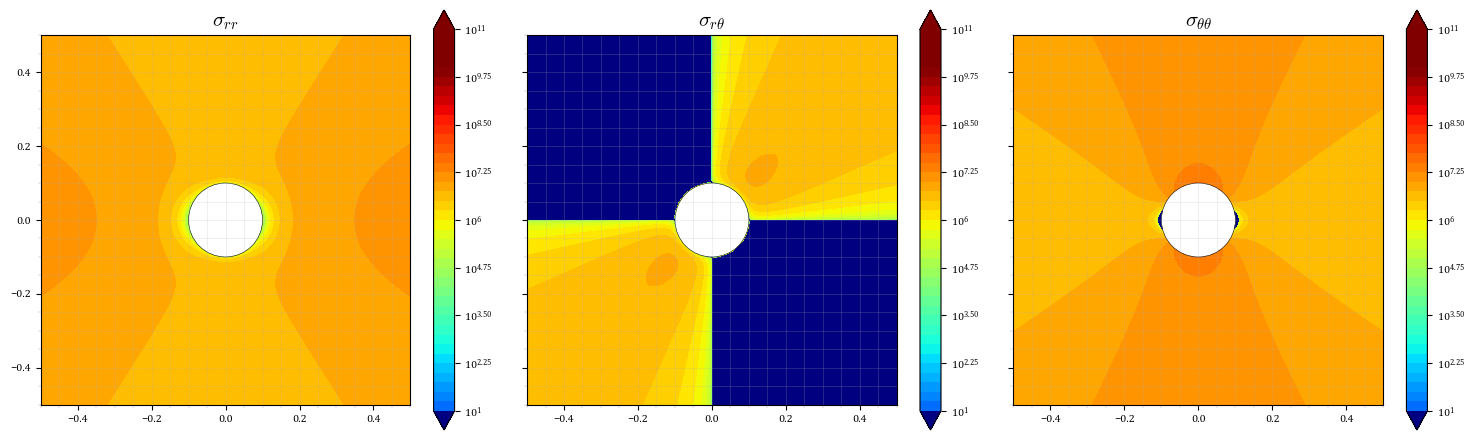

In [3]:
# PLOT THE FULL DOMAIN

# Points in space
lim = 1
npts = 200
x = np.linspace(-lim,lim,npts)
X, Y = np.meshgrid(x, x)
SIGTT = np.zeros_like( X ) ; SIGRT = np.zeros_like( X ) ; SIGRR = np.zeros_like( X )

# Calculate the kirsch solution in space
for i in np.arange(npts) :
    for j in np.arange(npts) :
        SIGTT[i,j], SIGRT[i,j], SIGRR[i,j] = \
            kirsch(X[i,j],Y[i,j])

# Do the plotting             
fig, [ax1,ax2,ax3] = plt.subplots( 1, 3, sharey=True )
fig.set_size_inches(15,4.5)

plot_well( X, Y, SIGRR, ax1, r"$\sigma_{rr}$" )
plot_well( X, Y, SIGRT, ax2, r"$\sigma_{r\theta}$" )
plot_well( X, Y, SIGTT, ax3, r"$\sigma_{\theta\theta}$" )

fig.tight_layout()
fig.savefig(f'kirsch.svg', transparent=True)


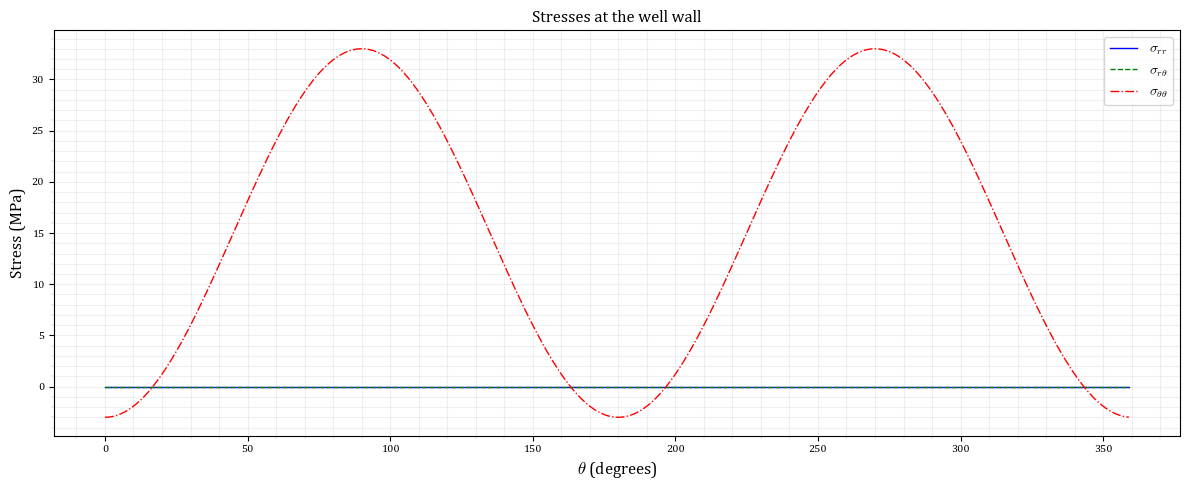

In [4]:
# PLOT STRESS AROUND ON THE WALL OF THE WELL

# Points in space
lim = 1
npts = 360
THETA = np.zeros( npts )
SIGTT = np.zeros( npts ) 
SIGRT = np.zeros( npts ) 
SIGRR = np.zeros( npts ) 

# Calculate the kirsch solution in space
R_ = R
for i in np.arange(npts) :
    theta = 2 * np.pi * (i) / npts
    THETA[i] = theta
    SIGTT[i], SIGRT[i], SIGRR[i] = kirsch_rt(R_, theta)

# Do the plotting             
fig, ax = plt.subplots( 1, 1, sharey=True )
fig.set_size_inches(12,5)

ax.plot( THETA*180/np.pi, SIGRR/1e6, '-', label=r"$\sigma_{rr}$" )
ax.plot( THETA*180/np.pi, SIGRT/1e6, '--', label=r"$\sigma_{r\theta}$" )
ax.plot( THETA*180/np.pi, SIGTT/1e6, '-.', label=r"$\sigma_{\theta\theta}$" )

ax.set_xlabel("$\\theta$ (degrees)")
ax.set_ylabel("Stress (MPa)")
ax.set_title("Stresses at the well wall", fontsize=12)
ax.legend()

fig.tight_layout()
fig.savefig(f'kirsch_wall.svg', transparent=True)

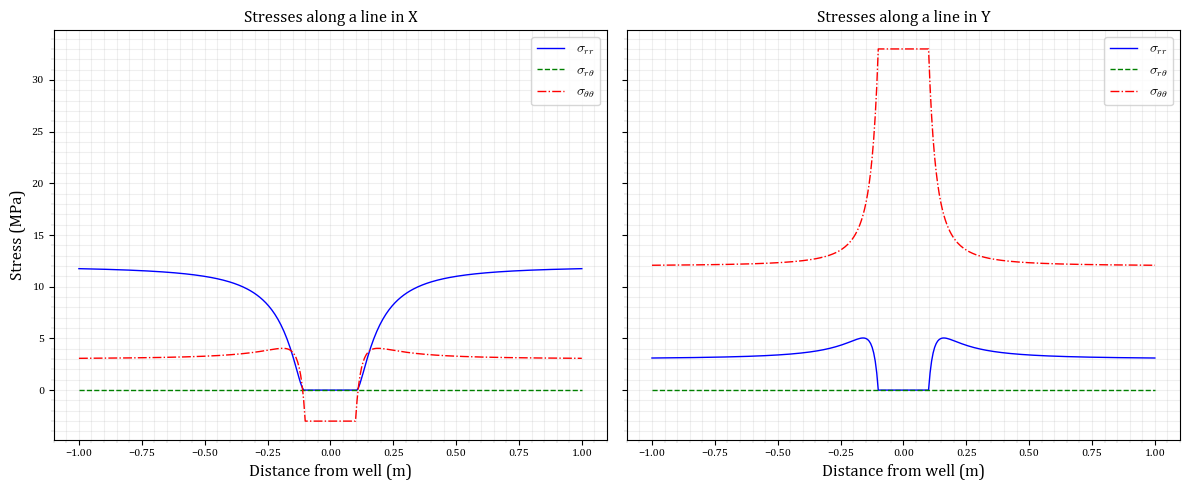

In [5]:
# PLOT STRESS AS A FUNCTION OF DISTANCE TO THE WELL

# Points in space
lim = 1
npts = 150
max_x = 1
X = np.array([ np.linspace( -max_x, -R, npts) , np.linspace( R, max_x, npts ) ]).flatten()
SIGTT = np.zeros( 2*npts ) 
SIGRT = np.zeros( 2*npts ) 
SIGRR = np.zeros( 2*npts ) 

# Calculate the kirsch solution in space
for i in np.arange(len(X)) :
    SIGTT[i], SIGRT[i], SIGRR[i] = kirsch_rt(X[i], 0)

# Do the plotting             
fig, [ax1, ax2] = plt.subplots( 1, 2, sharey=True )
fig.set_size_inches(12,5)

ax=ax1

ax.set_yticks( np.linspace(-60, 60, 25) )

ax.plot( X, SIGRR/1e6, '-', label=r"$\sigma_{rr}$" )
ax.plot( X, SIGRT/1e6, '--', label=r"$\sigma_{r\theta}$" )
ax.plot( X, SIGTT/1e6, '-.', label=r"$\sigma_{\theta\theta}$" )

# ax.set_ylim(-1e9, 10)
ax.set_xlabel("Distance from well (m)")
ax.set_ylabel("Stress (MPa)")
ax.set_title("Stresses along a line in X", fontsize=12)
ax.legend()

# Calculate the kirsch solution in space
for i in np.arange(len(X)) :
    SIGTT[i], SIGRT[i], SIGRR[i] = kirsch_rt(X[i], np.pi/2)

ax=ax2
ax.plot( X, SIGRR/1e6, '-', label=r"$\sigma_{rr}$" )
ax.plot( X, SIGRT/1e6, '--', label=r"$\sigma_{r\theta}$" )
ax.plot( X, SIGTT/1e6, '-.', label=r"$\sigma_{\theta\theta}$" )

# ax.set_ylim(-1e9, 10)
ax.set_xlabel("Distance from well (m)")
ax.set_title("Stresses along a line in Y", fontsize=12)
ax.legend()

fig.tight_layout()
fig.savefig(f'kirsch_wall.svg', transparent=True)

Interpolating SIGXX ...
Interpolating SIGYY ...
Interpolating SIGXY ...
Plotting ...


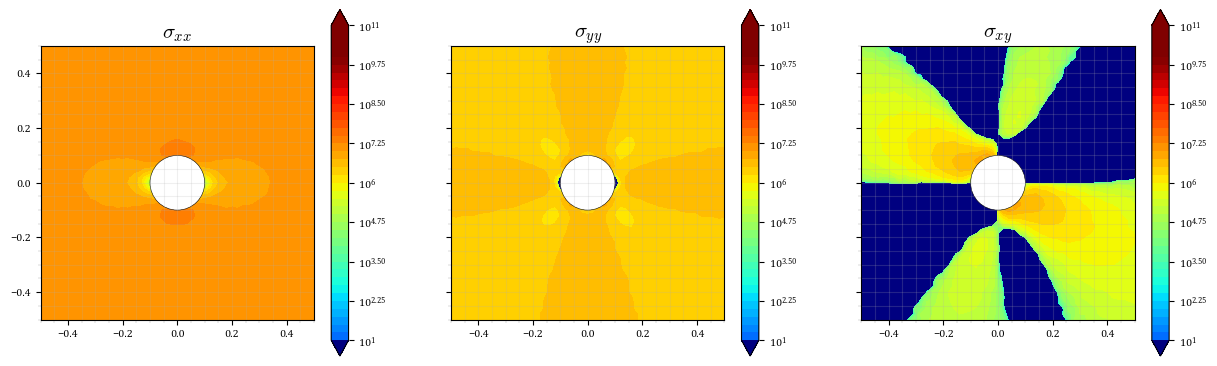

In [17]:
import pandas as pd

df = pd.read_csv( "freefem-kirsch-1.dat" )

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

X = df.x
Y = df.y
# Set up a regular grid of interpolation points
xi, yi = np.linspace(X.min(), X.max(), 100), np.linspace(Y.min(), Y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate - invert signal, as frefem++ is getting the wrong convetion
print("Interpolating SIGXX ...")
rbfxx = scipy.interpolate.Rbf(X, Y, df.sigxx, function='linear')
SIGXX = -rbfxx(xi, yi)

print("Interpolating SIGYY ...")
rbfyy = scipy.interpolate.Rbf(X, Y, df.sigyy, function='linear')
SIGYY = -rbfyy(xi, yi)

print("Interpolating SIGXY ...")
rbfxy = scipy.interpolate.Rbf(X, Y, df.sigxy, function='linear')
SIGXY = -rbfxy(xi, yi)

print("Plotting ...")

fig, [ax1,ax2,ax3] = plt.subplots( 1, 3, sharey=True )
fig.set_size_inches(15,4.5)

plot_well( xi, yi, SIGXX, ax1, r"$\sigma_{xx}$" )
plot_well( xi, yi, SIGYY, ax2, r"$\sigma_{yy}$" )
plot_well( xi, yi, SIGXY, ax3, r"$\sigma_{xy}$" )


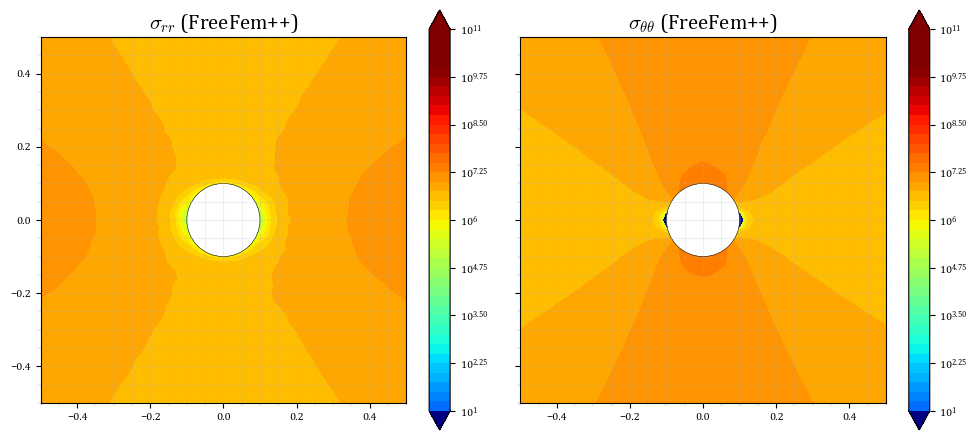

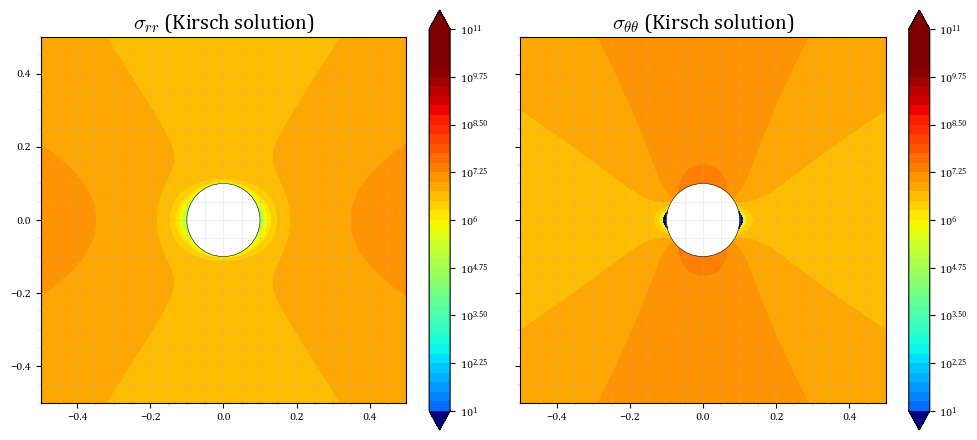

In [19]:
# Rotate stresses from FREEFEM to get sigrr and sigtt

SIGRR = np.zeros_like( SIGXX )
SIGTT = np.zeros_like( SIGXX )

for i in np.arange(len(SIGXX)) :
    for j in np.arange(len(SIGXX[i])) :
        x,y = xi[i,j], yi[i,j]
        sxx, syy, sxy = SIGXX[i,j], SIGYY[i,j], SIGXY[i,j]

        r = np.sqrt( y**2 + x**2 )
        theta = np.arctan2( y , x )
        ROT = np.array( [ [ np.cos(theta), -np.sin(theta) ], [ np.sin(theta), np.cos(theta) ] ] )
        SIGij = np.array( [ [ sxx, sxy ] , [ sxy, syy ] ] )
        SIGmn = ROT.T @ SIGij @ ROT 
        SIGRR[i,j] = SIGmn[0,0]
        SIGTT[i,j] = SIGmn[1,1]

fig, [ax1,ax2] = plt.subplots( 1, 2, sharey=True )
fig.set_size_inches(10,4.5)
plot_well( xi, yi, SIGRR, ax1, r"$\sigma_{rr}$ (FreeFem++)" )
plot_well( xi, yi, SIGTT, ax2, r"$\sigma_{\theta\theta}$ (FreeFem++)" )
fig.tight_layout()


#
# Compare to the analyticallim = 1
#

npts = 200
x = np.linspace(-lim,lim,npts)
X, Y = np.meshgrid(x, x)
SIGTT = np.zeros_like( X ) ; SIGRT = np.zeros_like( X ) ; SIGRR = np.zeros_like( X )

# Calculate the kirsch solution in space
for i in np.arange(npts) :
    for j in np.arange(npts) :
        SIGTT[i,j], SIGRT[i,j], SIGRR[i,j] = \
            kirsch(X[i,j],Y[i,j])

# Do the plotting             
fig, [ax1,ax2] = plt.subplots( 1, 2, sharey=True )
fig.set_size_inches(10,4.5)

plot_well( X, Y, SIGRR, ax1, r"$\sigma_{rr}$ (Kirsch solution)" )
plot_well( X, Y, SIGTT, ax2, r"$\sigma_{\theta\theta}$ (Kirsch solution)" )
fig.tight_layout()


(-20000000.0, 15000000.0)

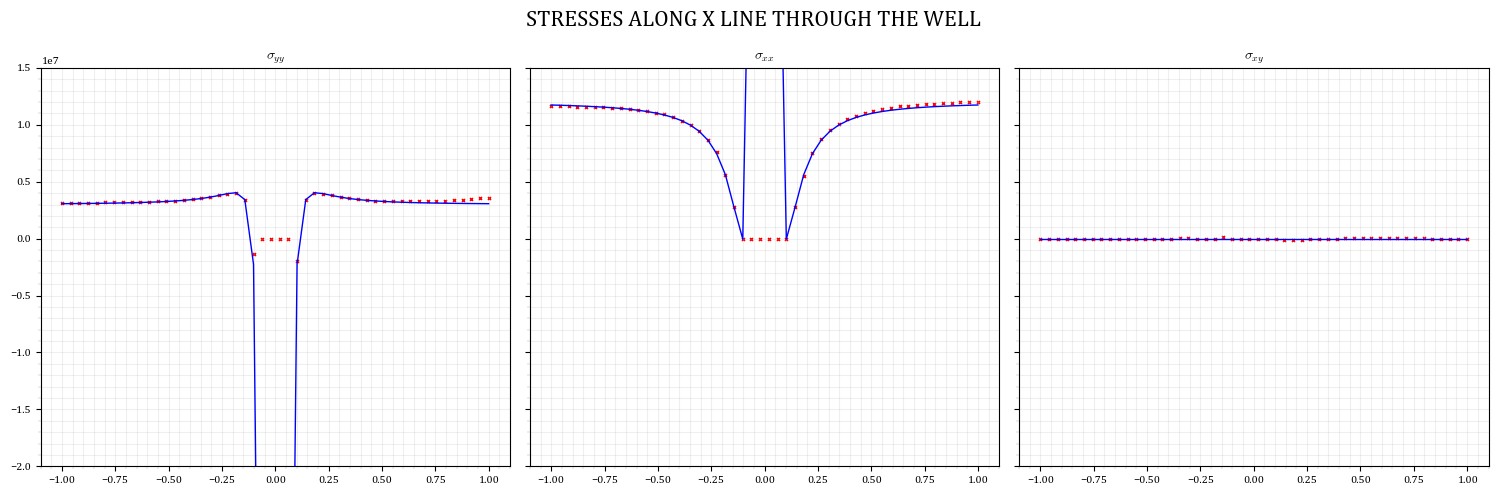

In [20]:
x = np.linspace(-1,1,50)
y = np.zeros_like(x)

# Invert signal as freefem is delivering the wrong convention
syy = -rbfyy(x,y)
sxx = -rbfxx(x,y)
sxy = -rbfxy(x,y)

# Analytical
a_stt = np.zeros_like(x)
a_srr = np.zeros_like(x)
a_srt = np.zeros_like(x)
for i in np.arange(len(x)) :
    a_stt[i], a_srt[i], a_srr[i] = kirsch(x[i], y[i])

fig, [ax1,ax2,ax3] = plt.subplots(1,3, sharey=True)
fig.set_size_inches(15,5)
ax1.scatter(x,syy, marker='x', s=5, c='r')
ax1.plot(x,a_stt)
ax1.set_title("$\sigma_{yy}$")

ax2.scatter(x,sxx, marker='x', s=5, c='r')
ax2.plot(x,a_srr)
ax2.set_title("$\sigma_{xx}$")

ax3.scatter(x,sxy, marker='x', s=5, c='r')
ax3.plot(x,a_srt)
ax3.set_title("$\sigma_{xy}$")

fig.suptitle('STRESSES ALONG X LINE THROUGH THE WELL', fontsize=16)

fig.tight_layout()

ax1.set_ylim(-2e7, 1.5e7)



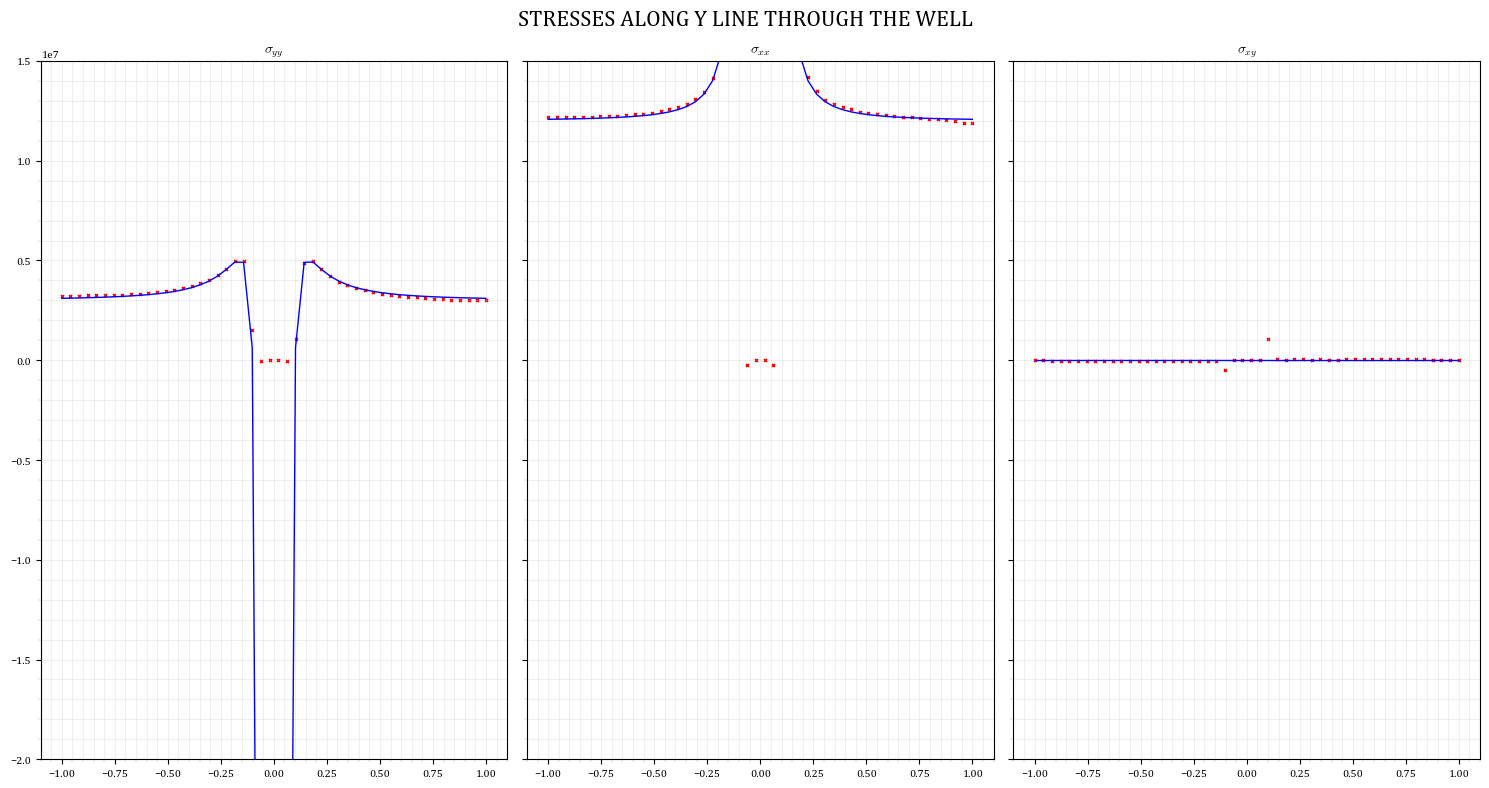

In [21]:
y = np.linspace(-1,1,50)
x = np.zeros_like(x)

syy = rbfyy(x,y)
sxx = rbfxx(x,y)
sxy = rbfxy(x,y)

# Analytical
a_stt = np.zeros_like(x)
a_srr = np.zeros_like(x)
a_srt = np.zeros_like(x)
for i in np.arange(len(x)) :
    a_stt[i], a_srt[i], a_srr[i] = kirsch(x[i], y[i])

fig, [ax1,ax2,ax3] = plt.subplots(1,3, sharey=True)
fig.set_size_inches(15,8)
ax1.scatter(y,-syy, marker='x', s=5, c='r')
ax1.plot(y,a_srr)
ax1.set_title("$\sigma_{yy}$")

ax2.scatter(y,-sxx, marker='x', s=5, c='r')
ax2.plot(y,a_stt)
ax2.set_title("$\sigma_{xx}$")

ax3.scatter(y,sxy, marker='x', s=5, c='r')
ax3.plot(y,a_srt)
ax3.set_title("$\sigma_{xy}$")

ax1.set_ylim(-2e7, 1.5e7)
fig.suptitle('STRESSES ALONG Y LINE THROUGH THE WELL', fontsize=16)
fig.tight_layout()

